# Exercise 4.1 - Consume Data using Fabric Data Science experience

## Exercise outline

1) **Read data from silver layer lakehouse tables using Apache Spark**
2) **Explore and Visualize Data using Notebooks**
3) **Train and register machine learning model**
4) **Perform Batch Scoring and save predictions to gold layer lakehouse**

> **NOTE: Please Attach Silver and Gold layer Lakehouses to this notebook before executing below steps** <br>
> Steps to attach lakehouses can be found [here](https://github.com/ekote/Build-Your-First-End-to-End-Lakehouse-Solution/blob/main/exercise-2/exercise-2.md#task-25-attach-the-bronze-lakehouse)

#### Step 0:  Define common parameters

In [ ]:
## Lakehouse Names
SILVER_LAKEHOUSE = "silvercleansed"
GOLD_LAKEHOUSE = "goldcurated"

#Table Names
TRAINING_TABLE = "green201501_cleansed"
EVAL_TABLE = "green202301_cleansed"
PREDICT_TABLE = "greentaxi_predicted"

# SET SQL Variables to explore data using Spark SQL
spark.sql(f"SET SILVER_LAKEHOUSE ={SILVER_LAKEHOUSE}")
spark.sql(f"SET GOLD_LAKEHOUSE ={GOLD_LAKEHOUSE}")
spark.sql(f"SET TRAINING_TABLE ={TRAINING_TABLE}")
spark.sql(f"SET EVAL_TABLE ={EVAL_TABLE}")
spark.sql(f"SET PREDICT_TABLE ={PREDICT_TABLE}")

## Step 1: Read data from Fabric lakehouse tables using Apache Spark
**Lakehouse**:
A lakehouse is a collection of files/folders/tables that represent a database over a data lake used by 
the Spark engine and SQL engine for big data processing and that includes enhanced capabilities for 
ACID transactions when using the open-source Delta formatted tables.

**Delta Lake**:Delta Lake is an open-source storage layer that brings ACID transactions, scalable metadata management, and batch and streaming data processing to Apache Spark. A Delta Lake table is a data table format that extends Parquet data files with a file-based transaction log for ACID transactions and scalable metadata management.

In [ ]:
# Read delta table from lakehouse - silver zone
data = spark.read.table(f"{SILVER_LAKEHOUSE}.{TRAINING_TABLE}")

# Step 2: Explore and Visualize Data

In this Step we will use seaborn, a Python data visualization library that provides a high-level interface for building visuals on dataframes and arrays. You can learn more about seaborn [here](https://seaborn.pydata.org/).

##### Import visualization libraries and set figure config

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})

In [ ]:
# Note: For the purpose of minimizing runtime in this exercise, We are using a 1/100 sample to explore and visualize ingested data
SEED = 1234
sampled_df = data.sample(True, 0.01, seed=SEED).toPandas()
sampled_df

##### Visual 1: Distribution of trip duration(minutes) on linear and logarithmic scale

In [ ]:
## Compute trip duration(in minutes) on the sample using pandas
sampled_df['trip_duration'] = (sampled_df['lpep_dropoff_datetime'] - sampled_df['lpep_pickup_datetime']).astype('timedelta64[s]').dt.seconds/60
sampled_df = sampled_df[sampled_df["trip_duration"] > 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(ax=axes[0],data=sampled_df,
            x="trip_duration",
            stat="count",
            discrete=True).set(title='Distribution of trip duration(minutes)')
sns.histplot(ax=axes[1],data=sampled_df,
            x="trip_duration",
            stat="count", 
            log_scale= True).set(title='Distribution of trip duration(log scale)')
axes[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.show()

#### Visual 2: Lets create bins to visualize duration of trips better

In [ ]:
## Create bins for trip_duration column
sampled_df.loc[sampled_df['trip_duration'].between(0, 10, 'both'), 'durationBin'] = '< 10 Mins'
sampled_df.loc[sampled_df['trip_duration'].between(10, 30, 'both'), 'durationBin'] = '10-30 Mins'
sampled_df.loc[sampled_df['trip_duration'].between(30, 60, 'both'), 'durationBin'] = '30-60 Mins'
sampled_df.loc[sampled_df['trip_duration'].between(60, 120, 'right'), 'durationBin'] = '1-2 Hrs'
sampled_df.loc[sampled_df['trip_duration'].between(120, 240, 'right'), 'durationBin'] = '2-4 Hrs'
sampled_df.loc[sampled_df['trip_duration'] > 240, 'durationBin'] = '> 4 Hrs'

# Plot histogram using the binned column
sns.histplot(data=sampled_df, x="durationBin", stat="count", discrete=True, hue = "durationBin")
plt.title("Trip Distribution by Duration Bins")
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')

#### Visual 3: Visualize the distribution of trip_duration and trip_distance and classify by passenger_count

In [ ]:
sns.scatterplot(data=sampled_df, x="trip_distance", y="trip_duration", hue="passenger_count")
plt.show()

#### Visual 4: Visualize distribution of passenger_count per trip

In [ ]:
sns.histplot(data=sampled_df, x="passenger_count", stat="count", discrete=True)
plt.title("Distribution of passenger count")
plt.xlabel('No. of Passengers')
plt.ylabel('Number of trips')

#### Visual 5:  Create boxplots to visualize the distribution of trip_duration by passenger count
A boxplot is a useful tool to understand the variability, symmetry, and outliers of the data.
- In first figure lets visualize trip_duration without removing any outliers
- In the second figure we are removing trips with duration greater than 3 hours and zero passengers.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(ax=axes[0], data=sampled_df, x="passenger_count", y="trip_duration").set(title='Distribution of Trip duration by passenger_count')
sampleddf_clean = sampled_df[(sampled_df["passenger_count"] > 0) & (sampled_df["trip_duration"] < 60)]
sns.boxplot(ax=axes[1], data=sampleddf_clean, x="passenger_count", y="trip_duration").set(title='Distribution of Trip duration by passenger_count (outliers removed)')
plt.show()

#### Visual 6: Analyze the relationship of trip_duration and fare_amount classified by payment_type and VendorID using a scatterplot/subplots

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(ax =axes[0], data=sampled_df, x="fare_amount", y="trip_duration",  hue="payment_type")
sns.scatterplot(ax =axes[1],data=sampled_df, x="fare_amount", y="trip_duration",  hue="VendorID")
plt.title("Distribution of trip_duration by fare_amount")
plt.show()

#### Visual 7: Analyze the frequency of the taxi trips by hour of the day

In [ ]:
sampled_df['hour'] = sampled_df['lpep_pickup_datetime'].dt.hour
sampled_df['dayofweek'] = sampled_df['lpep_dropoff_datetime'].dt.dayofweek
sampled_df['dayname'] = sampled_df['lpep_dropoff_datetime'].dt.day_name()
sns.histplot(data=sampled_df, x="hour", stat="count", discrete=True, kde=True)
plt.title("Distribution by Hour of the day")
plt.xlabel('Hours')
plt.ylabel('Count of trips')
plt.show()

#### Visual 8: Analyze average taxi trip duration by hour and day of the week using a heatmap

In [ ]:
pv_df = sampled_df[sampled_df["trip_duration"]<180]\
        .groupby(["hour","dayname"]).mean("trip_duration")\
        .reset_index().pivot(index = "hour", columns= "dayname", values = "trip_duration")
sns.heatmap(pv_df,annot=True,fmt='.2f', cmap="Blues").set(xlabel=None)

#### Visual 9: Create a Correlation plot 
A correlation plot is a useful tool for exploring the relationships among numerical variables in a dataset. It displays the data points for each pair of variables as a scatterplot, and also calculates the correlation coefficient for each pair. The correlation coefficient indicates how strongly and in what direction the variables are related. A positive correlation means that the variables tend to increase or decrease together, while a negative correlation means that they tend to move in opposite directions.

In [ ]:
cols_to_corr = ['trip_duration','fare_amount', 'passenger_count', 'trip_distance', 'extra', 'mta_tax',
       'improvement_surcharge', 'tip_amount', 'hour',"dayofweek"]
sns.heatmap(data = sampled_df[cols_to_corr].corr(),annot=True,fmt='.3f', cmap="Blues")

# Step 3: Train and register a machine learning model
In this Step you will learn to train a machine learning model to predict the total ride duration (trip_duration) of green taxi trips in New York City based on various factors such as pickup and drop-off locations, distance, date, time, number of passengers, and rate code.

Once a model is trained, you will learn to register the trained model, and log hyperaparameters used and evaluation metrics using Fabric's native integration with the MLflow framework.

[MLflow](https://mlflow.org/docs/latest/index.html) is an open source platform for managing the machine learning lifecycle with features like Tracking, Models, and Model Registry. MLflow is natively integrated with Fabric Data Science Experience.

#### Import mlflow and create an experiment to log the run

In [ ]:
# Create Experiment to Track and register model with mlflow
import mlflow
print(f"mlflow lbrary version: {mlflow.__version__}")
EXPERIMENT_NAME = "nyctaxi_trip_duration"
mlflow.set_experiment(EXPERIMENT_NAME)

#### Read Cleansed and prepared data from silver zone delta table

In [ ]:
training_df = spark.read.table(f"{SILVER_LAKEHOUSE}.{TRAINING_TABLE}")
                       

#### Perform random split to get train and test datasets and define categorical and numeric features

In [ ]:
TRAIN_TEST_SPLIT = [0.75, 0.25]
train_df, test_df = training_df.randomSplit(TRAIN_TEST_SPLIT, seed=SEED)

# Cache the dataframes to improve the speed of repeatable reads
train_df.cache()
test_df.cache()

print(f"train set count:{train_df.count()}")
print(f"test set count:{test_df.count()}")

categorical_features = ["timeBins","VendorID","weekDayName","pickupHour","RatecodeID"]
numeric_features = ['passenger_count', "trip_distance"]

#### Define the steps to perform additional feature engineering and train the model using Spark ML pipelines and Microsoft SynapseML library
You can learn more about Spark ML pipelines [here](https://spark.apache.org/docs/latest/ml-pipeline.html), and SynapseML is documented [here](https://microsoft.github.io/SynapseML/docs/about/)

The algorithm used for this exercise, [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/) is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms. It is an open source project developed by Microsoft and supports regression, classification and many other machine learning scenarios. Its main advantages are faster training speed, lower memory usage, better accuracy, and support for distributed learning.

In [ ]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from synapse.ml.core.platform import *
from synapse.ml.lightgbm import LightGBMRegressor

# Define a pipeline steps for training a LightGBMRegressor regressor model
def lgbm_pipeline(categorical_features,numeric_features, hyperparameters):
    # String indexer
    stri = StringIndexer(inputCols=categorical_features, 
                        outputCols=[f"{feat}Idx" for feat in categorical_features]).setHandleInvalid("keep")
    # encode categorical/indexed columns
    ohe = OneHotEncoder(inputCols= stri.getOutputCols(),  
                        outputCols=[f"{feat}Enc" for feat in categorical_features])
    
    # convert all feature columns into a vector
    featurizer = VectorAssembler(inputCols=ohe.getOutputCols() + numeric_features, outputCol="features")

    # Define the LightGBM regressor
    lgr = LightGBMRegressor(
        objective = hyperparameters["objective"],
        alpha = hyperparameters["alpha"],
        learningRate = hyperparameters["learning_rate"],
        numLeaves = hyperparameters["num_leaves"],
        labelCol="trip_duration",
        numIterations = hyperparameters["iterations"],
    )
    # Define the steps and sequence of the SPark ML pipeline
    ml_pipeline = Pipeline(stages=[stri, ohe, featurizer, lgr])
    return ml_pipeline


#### Define Training Hyperparameters
Hyperparameters are the parameters that you can change to control how a machine learning model is trained. Hyperparameters can affect the speed, quality and accuracy of the model. Some common methods to find the best hyperparameters are by testing different values, using a grid or random search, or using a more advanced optimization technique.
The hyperparameters for the lightgbm model in this exercise have been pre-tuned using a distributed gridsearch run using [hyperopt](https://github.com/hyperopt/hyperopt)

In [ ]:
# Tuned hyperparameters for LightGBM Model
LGBM_PARAMS = {"objective":"regression",
    "alpha":0.08373361416254149,
    "learning_rate":0.0801709918703746,
    "num_leaves":92,
    "iterations":200}

#### Fit the lightgbm pipeline with defined hyperparameters on the training dataframe and generate predictions on the test dataset

In [ ]:
if mlflow.active_run() is None:
    mlflow.start_run()
run = mlflow.active_run()
print(f"Active experiment run_id: {run.info.run_id}")
lg_pipeline = lgbm_pipeline(categorical_features,numeric_features,LGBM_PARAMS)
lg_model = lg_pipeline.fit(train_df)

# Get Predictions
lg_predictions = lg_model.transform(test_df)
## Caching predictions to run model evaluation faster
lg_predictions.cache()
print(f"Prediction run for {lg_predictions.count()} samples")

#### Compute Model Statistics for evaluating performance of the trained LightGBMRegressor model

In [ ]:
from synapse.ml.train import ComputeModelStatistics
import json
lg_metrics = ComputeModelStatistics(
    evaluationMetric="regression", labelCol="trip_duration", scoresCol="prediction"
).transform(lg_predictions)
lg_metrics_dict = json.loads(lg_metrics.toJSON().first())
display(lg_metrics)

#### Register the trained LightGBMRegressor model using MLflow

In [ ]:
from mlflow.models.signature import ModelSignature 
from mlflow.types.utils import _infer_schema 

# Define a function to register a spark model
def register_spark_model(run, model, model_name,signature,metrics, hyperparameters):
        # log the model, parameters and metrics
        mlflow.spark.log_model(model, artifact_path = model_name, signature=signature, registered_model_name = model_name, dfs_tmpdir="Files/tmp/mlflow") 
        mlflow.log_params(hyperparameters) 
        mlflow.log_metrics(metrics) 
        model_uri = f"runs:/{run.info.run_id}/{model_name}" 
        print(f"Model saved in run{run.info.run_id}") 
        print(f"Model URI: {model_uri}")
        return model_uri

# Define Signature object 
sig = ModelSignature(inputs=_infer_schema(train_df.select(categorical_features + numeric_features)), 
                     outputs=_infer_schema(train_df.select("trip_duration"))) 

ALGORITHM = "lightgbm" 
model_name = f"{EXPERIMENT_NAME}_{ALGORITHM}"

# Call model register function
model_uri = register_spark_model(run = run,
                                model = lg_model, 
                                model_name = model_name, 
                                signature = sig, 
                                metrics = lg_metrics_dict, 
                                hyperparameters = LGBM_PARAMS)
mlflow.end_run()

please upload to lakehouse

##### Once a Machine Learning model is registered you can view the ML Model artifact in your workspace UI and open the model to view and interact with various ML Model properties like versions, model files, metrics, hyperparameters and more.

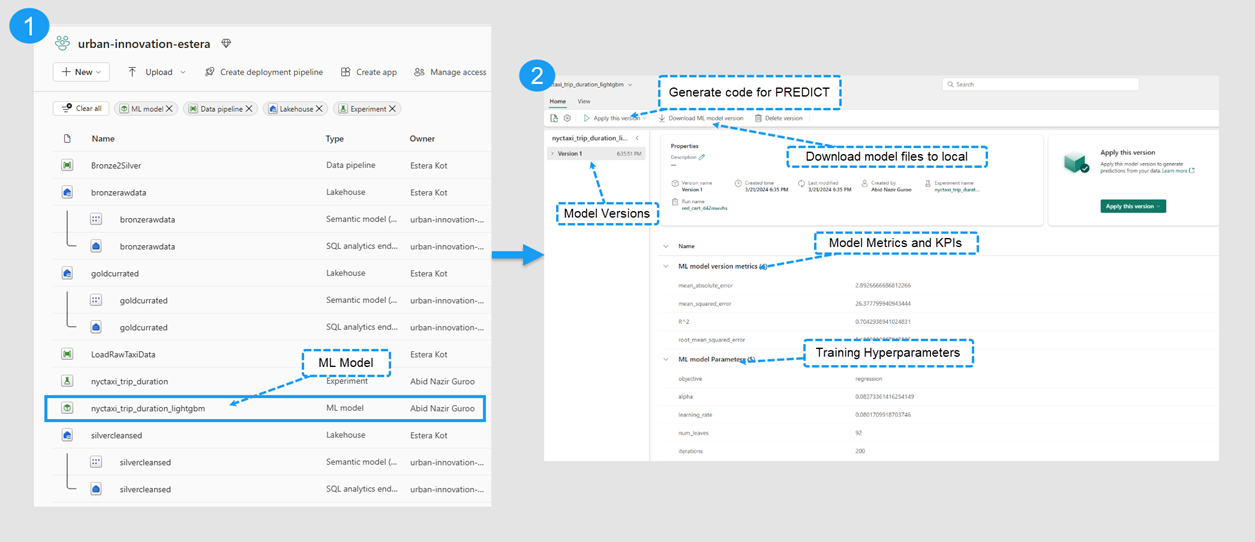

# Step 5: Perform batch scoring and save predictions to lakehouse

#### Read cleansed data from lakehouse for the year 2023 to generate predictions

In [ ]:
input_df = spark.read.table(f"{SILVER_LAKEHOUSE}.{EVAL_TABLE}")

#### Get the trained and registered model to generate predictions

In [ ]:
import mlflow
## Define model_uri to fetch the model
version = "latest"
model_uri = f"models:/{model_name}/{version}"
print(f"Loading {version} version of the registered model - {model_name}")
loaded_model = mlflow.spark.load_model(model_uri)

#### Run model transform on the input dataframe to generate predictions and remove unnecessary vector features created for model training

In [ ]:
# Generate predictions by applying model transform on the input dataframe
predictions = loaded_model.transform(input_df)
cols_toremove = ['storeAndFwdFlagIdx', 'timeBinsIdx', 'VendorIDIdx', 'payment_typeIdx', 'VendorIDEnc',
 'rateCodeIDEnc', 'payment_typeEnc', 'weekDayEnc', 'pickupHourEnc', 'storeAndFwdFlagEnc', 'timeBinsEnc', 'features','weekDayNameIdx',
 'pickupHourIdx', 'rateCodeIDIdx', 'weekDayNameEnc']
output_df = predictions.withColumnRenamed("prediction", "predictedtrip_duration").drop(*cols_toremove)

#### Save predictions to gold layer lakehouse delta table

In [ ]:
table_name = "nyctaxi_green_pred"
output_df.write.mode("overwrite").format("delta").saveAsTable(f"{GOLD_LAKEHOUSE}.{PREDICT_TABLE}")
print(f"Output Predictions saved to delta table: {table_name}")

#### Preview and explore predicted dataframe using SparkSQL

In [ ]:
%%sql
SELECT * FROM ${GOLD_LAKEHOUSE}.${PREDICT_TABLE} LIMIT 20